# Data Science Fundamentals

In this module, we will examine dataset partitioning, covering cross-validation, feature selection and extraction, and other methods. In addition, we will explore parameter tuning for training optimal machine learning models. We will also introduce the python package used in the introductory course, scikit-learn, and discuss linear models. You will train a linear model on the NCAR dataset introduced in the previous module.

**Please cite the notebook as follows:**

Avery, K., 2020: "Data science fundamentals: Python tutorial". https://github.com/alburke/ams-2020-ml-python-course/tree/master/Introduction_To_Machine_Learning/data_science_fundamentals

## References

This notebook refers to a few publications, listed below.

Chisholm, D., J. Ball, K. Veigas, and P. Luty, 1968: "The diagnosis of upper-level humidity." *Journal of Applied Meteorology*, **7 (4)**, 613-619.

Hsu, W., and A. Murphy, 1986: "The attributes diagram: A geometrical framework for assessing the quality of probability forecasts." *International Journal of Forecasting*, **2**, 285–293, https://doi.org/10.1016/0169-2070(86)90048-8.

Lagerquist, R., and D.J. Gagne II, 2019: "Basic machine learning for predicting thunderstorm rotation: Python tutorial". https://github.com/djgagne/ams-ml-python-course/blob/master/module_2/ML_Short_Course_Module_2_Basic.ipynb.

McGovern, A., D. Gagne II, J. Basara, T. Hamill, and D. Margolin, 2015: "Solar energy prediction: An international contest to initiate interdisciplinary research on compelling meteorological problems." *Bulletin of the American Meteorological Society*, **96 (8)**, 1388-1395.

Metz, C., 1978: "Basic principles of ROC analysis." *Seminars in Nuclear Medicine*, **8**, 283–298, https://doi.org/10.1016/S0001-2998(78)80014-2.

Refaeilzadeh P., Tang L., Liu H. (2009) Cross-Validation. In: LIU L., ÖZSU M.T. (eds) Encyclopedia of Database Systems. Springer, Boston, MA

Roebber, P., 2009: "Visualizing multiple measures of forecast quality." *Weather and Forecasting*, **24**, 601-608, https://doi.org/10.1175/2008WAF2222159.1.


## Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

### Scikit-Learn

Scikit-learn is an open-source Python library for machine learning. It's comprehensive, well-documented, and popular across disciplines. We'll use it later in this module and throughout future modules.

Find the user guide here: https://scikit-learn.org/stable/user_guide.html

And the API here: https://scikit-learn.org/stable/modules/classes.html


## Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
%matplotlib inline
import sys
from os.path import dirname, abspath
sys.path.insert(1, abspath('')+"/introduction_to_machine_learning")

import copy
import warnings
import pandas
import numpy
import matplotlib.pyplot as pyplot
import data_science_fundamentals.utils as utils

warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

MODULE2_DIR_NAME = '.'
SHORT_COURSE_DIR_NAME = '..'

## Dataset Partitioning

### Training Data
Train the model (*e.g.*, adjust weights in linear regression or neural net, adjust decision boundaries in decision tree).
<br>
### Validation Data
Choose the best hyperparameters (*e.g.*, learning rate, number of iterations, number of layers in a neural net).
<br>
### Testing Data 
Evaluate the "best" model on independent data.

The "best" model is the one that performs best on validation data. There are many ways to define the best performance (*e.g.*, lowest mean squared error, lowest cross-entropy, highest area under ROC curve, etc.).
<br><br>
_____
### Statistical Independence 

Training, validation, and testing (TV&T) sets should be **statistically independent**.
<br><br>
For example, 
 - **In disease prediction:**
     - If there are multiple tissue scans from the same patient, they should all be in the same set.
     - Multiple patients in the same family should also be in the same set.
<br><br>
 - **In storm-hazard prediction:**
     - If there are multiple radar scans from the same storm, they should all be in the same set.
     - Related storms (*e.g.*, part of the same MCS) should also be in the same set.
<br><br>
 - **In weather prediction generally:**
     - Data should be free of temporal autocorrelation.
     - For storm-scale phenomena, it is probably sufficient to leave a one-day gap between each pair of datasets.
     - For synoptic-scale phenomena, you may need a one-week gap between each pair of datasets.<br><br>
     - If training on one area and applying to a different area, data should be free of spatial autocorrelation.
     - For example, say you are training on a model on North America but applying in real-time to Africa.
     - TV&T sets should contain spatially non-overlapping parts of North America.
     - When you test on a part of North America that has not been used to train/validate the model, hopefully this gives you a reasonable estimation of performance in Africa, which also has not been used to train/validate the model.

**Question:** Our NCAR dataset contains data from the year 2010 to the year 2017. Which data should be in which set?

## Find Input Files

Now, find the input files for the training (years 2010-14), validation (year 2015), and testing (years 2016-17) sets.

In [2]:
training_file_names = utils.find_many_feature_files(
    first_date_string='20100101', last_date_string='20141231')

validation_file_names = utils.find_many_feature_files(
    first_date_string='20150101', last_date_string='20151231')

testing_file_names = utils.find_many_feature_files(
    first_date_string='20160101', last_date_string='20171231')

## Read Data

The next cell reads training, validation, and testing data and explores the contents of one file.

In [3]:
"""
read CSV feature files:
metadata_table -- pandas DataFrame with metadata. Each row is one
        storm object.
predictor_table -- pandas DataFrame with predictor values. Each row
        is one storm object.
target_table -- pandas DataFrame with target values. Each row is one
        storm object.
"""
(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_feature_files(training_file_names)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_feature_files(validation_file_names)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_feature_files(testing_file_names)

# Explore file contents
print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)



--------------------------------------------------


Variables in metadata are as follows:
['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date', 'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC']

Predictor variables are as follows:
['REFL_COM_mean', 'REFL_COM_max', 'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10', 'REFL_COM_percentile_25', 'REFL_COM_percentile_50', 'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean', 'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10', 'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75', 'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std', 'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50', 'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min', 'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50', 'T2_percentile_75', 'T2_percentile_90', 'area', 'eccentricity', 'major_axis_length', 'minor_axis_length', 'orientation']

Target variable is as follows:

## Normalization

Each predictor variable is transformed independently to $z$-scores (or another normalization method), using the mean and standard deviation from the training data. Validation and testing data should also be normalized, but using the means and standard deviations from the training data. For more on normalization, see module 1 of this course.
<br><br>
**Question:** why is it a bad idea to use the validation/testing data to compute means and standard deviations (or any other data-processing parameters)?

### Normalization Code

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each predictor, based only on the training data.
 - Normalizes the training, validation, and testing data, using these normalization params.
 - Denormalizes the training data and ensures that denormalized values = original values (sanity check).

In [5]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict)

Original values of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "REFL_COM_mean" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "REFL_COM_mean" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


## Linear Regression

To demonstrate the concepts in the rest of this module, we are going to train a simple linear model on our data.

**Linear regression fits the following equation to the training data.**

 $\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$

 - $x_j$ = $j^{\textrm{th}}$ predictor variable
 - $\beta_j$ = coefficient for $j^{\textrm{th}}$ predictor variable (adjusted during training)
 - $M$ = number of predictor variables
 - $\beta_0$ = bias coefficient or "intercept" (adjusted during training)
 - $\hat{y}$ = prediction for target variable (in this case, max future vorticity within storm, in s$^{-1}$)

<br>
**The weights ($\beta_0$ and $\beta_j$) are trained to minimize the mean squared error (MSE).**  This is why linear regression is often called "least-squares linear regression".

$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$

 - $y_i$ = actual target value for $i^{\textrm{th}}$ example (in this case, one example is one storm cell at one time, or one "storm object")
 - $\hat{y}_i$ = predicted target value for $i^{\textrm{th}}$ example
 - $N$ = number of training examples

Combining the two equations yields the following, where $x_{ij}$ is the $j^{\textrm{th}}$ predictor for the $i^{\textrm{th}}$ example.

$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2$

The derivatives of model coefficients with respect to MSE are as follows.

$\frac{\partial}{\partial \beta_0}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
<br>
$\frac{\partial}{\partial \beta_j}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$

**During training, the weights ($\beta_0$ and $\beta_j$) are adjusted over many iterations.**  After each iteration, the "gradient-descent rule" (shown below) is applied, where $\alpha \in \left(0, 1\right]$ is the learning rate.

$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial}{\partial \beta_0}(\textrm{MSE})$
<br>
$\beta_j \leftarrow \beta_j - \alpha \frac{\partial}{\partial \beta_j}(\textrm{MSE})$

## Linear Regression: Example

**The next cell does the following:**

 - Trains a linear-regression model (with default hyperparameters) to predict max future rotation in each storm.
 - Evaluates the model on both training and validation data.

**For both training and validation data, this cell reports the following quantities:**

 - Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$
 - Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$
 - Mean signed error ("bias"): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
 - MAE skill score.  This is defined as follows, where MAE is the MAE of the model and $\textrm{MAE}_{\textrm{climo}}$ is the MAE obtained by always predicting "climatology" (the average in the training data).

$\textrm{MAE skill score} = \frac{\textrm{MAE}_{\textrm{climo}} - \textrm{MAE}}{\textrm{MAE}_{\textrm{climo}}}$

 - MSE skill score, defined as follows.

$\textrm{MSE skill score} = \frac{\textrm{MSE}_{\textrm{climo}} - \textrm{MSE}}{\textrm{MSE}_{\textrm{climo}}}$

Finally, this cell plots a **reliability curve**, which shows the conditional mean observation for each forecast value.  This allows you to identify conditional bias (bias that occurs for certain forecast values).

Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 1.773e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


--------------------------------------------------


Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.048e-06 s^-2
Validation bias (mean signed error) = -9.007e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


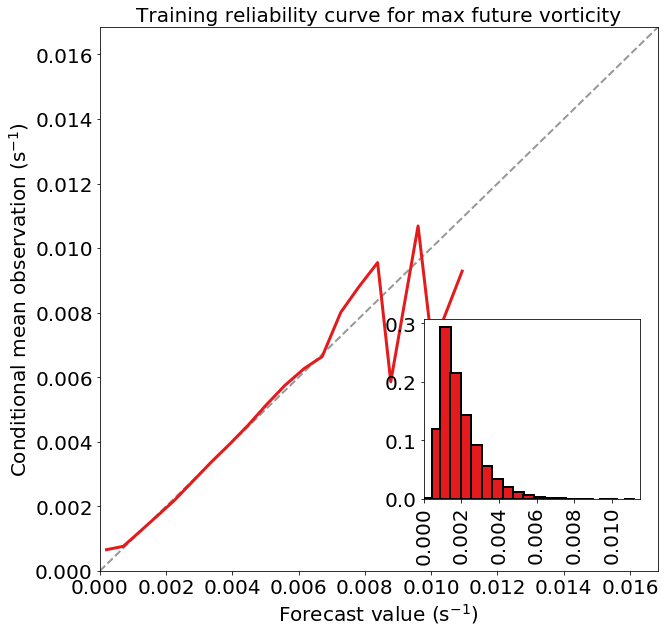

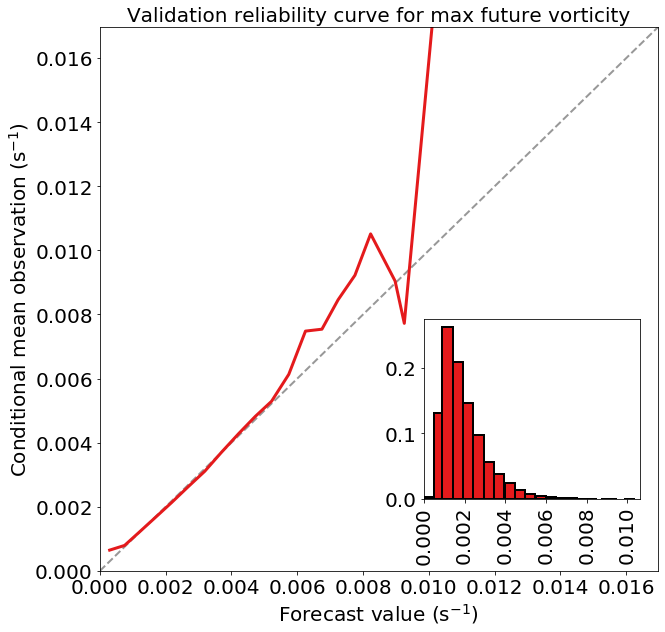

In [6]:
linreg_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=0.)

_ = utils.train_linear_regression(
    model_object=linreg_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linreg_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linreg_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

## Overfitting

You can't talk about machine learning without talking about overfitting. Overfitting occurs when the model performs well on training data but does not generalize well to new data.
<br><br>
Overfitting usually occurs in the following scenarios:
 - **Training set is small**.
 - Training set includes **inappropriate predictors**.
 - Training set is **not representative of the real world**.
<br><br>
 **Examples of inappropriate predictors**:
 - Using storm ID to predict tornadoes.
 - Using patient ID to predict disease.
 - In general, using variables with no physical relationship to the target phenomenon.
<br><br>
 **Examples of non-representative training data**:
 - Different label distributions (*e.g.*, training set contains 50% tornadic storms, but in the real world $<$ 1% of storms are tornadic).
 - Different levels of data quality (*e.g.*, training on archived radar data but applying to real-time data).
<br><br>

You can **mitigate** overfitting by not making these mistakes, but these properties (appropriateness of predictor, representativity of training data, etc.) are not always clear. Many other issues can also lead to overfitting, so you also need the ability to **diagnose** overfitting. This is usually done by splitting data into 3 partitions: training, validation, and testing.

In the example above, the model is doing slightly better on the training data than the validation. Here's a clearer example of overfitting in linear regression: 

<img src="overfitting.png" alt="underfitting and overfitting for linear regression" width="1200" />

## Linear Regression: Coefficients

The next cell plots coefficients for the linear-regression model.  If predictor $x_j$ has a positive (negative) coefficient, the prediction increases (decreases) with $x_j$.
<br><br>
Keep in mind that all predictors have been normalized to the same scale ($z$-scores), so **generally** predictors with coefficients that are not near zero are more important.
<br><br>
Also, note that every predictor is used (that has a non-zero coefficient).

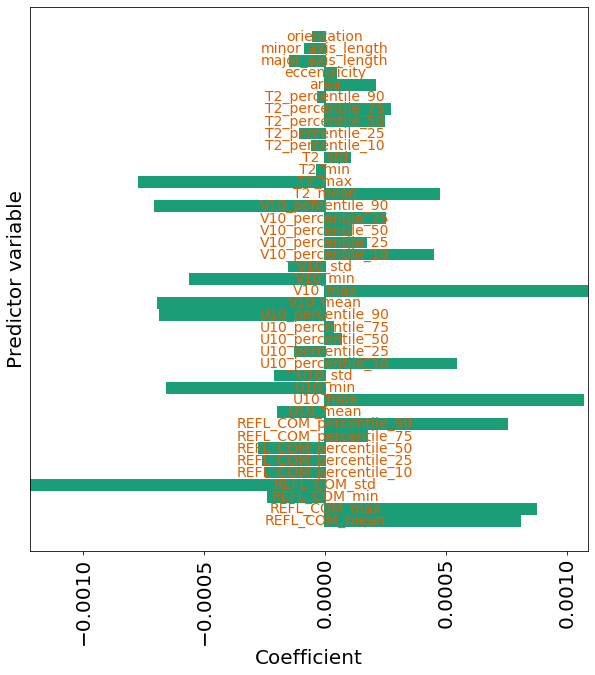

In [7]:
utils.plot_model_coefficients(
    model_object=linreg_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

In [45]:
# feature selection example
coefficients = linreg_model_object.coef_
epsilon = 0.00005
selected_coefficients = coefficients[numpy.absolute(coefficients) >= epsilon]
coefficient_indices = numpy.where(numpy.absolute(coefficients) < epsilon)

selected_training_pred_table = training_predictor_table.drop(labels=[training_predictor_table.columns[j] for j in list(coefficient_indices[0])], axis=1)

selected_validation_pred_table = training_predictor_table.drop(labels=[validation_predictor_table.columns[j] for j in list(coefficient_indices[0])], axis=1)

print(selected_training_pred_table.columns)
print(selected_coefficients)


Index(['REFL_COM_mean', 'REFL_COM_max', 'REFL_COM_min', 'REFL_COM_std',
       'REFL_COM_percentile_10', 'REFL_COM_percentile_25',
       'REFL_COM_percentile_50', 'REFL_COM_percentile_75',
       'REFL_COM_percentile_90', 'U10_mean', 'U10_max', 'U10_min', 'U10_std',
       'U10_percentile_10', 'U10_percentile_25', 'U10_percentile_50',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_std',
       'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'area', 'major_axis_length', 'minor_axis_length'],
      dtype='object')
[ 8.07503122e-04  8.70924511e-04 -2.34417512e-04 -1.51762859e-03
 -2.45330015e-04 -2.56776970e-04 -2.70657732e-04  1.72704346e-04
  7.54409084e-04 -1.92483563e-04  1.06698444e-03 -6.55004444e-04
 -2.06634064e-04  5.41267884e-04 -1.22953913e-04  6.70971303e-05
 -6.79974902

## Feature Selection and Feature Engineering

**Feature selection** refers to the process of choosing useful features for the model and discarding irrelevant ones, while **feature engineering** refers to the preprocessing of features into more meaningful ones (typically using domain knowledge). 

*Note:* **Feature extraction** is the dimensionality reduction of data into more meaningful features. It's very similar to feature engineering in that new features are created, but feature extraction uses mathematical techniques (*e.g.*, principal component analysis (PCA) or manifold learning methods) discussed in later sections. Feature engineering uses common sense or domain knowledge. 

There are several classes of feature selection techniques, including **filter**, **wrapper**, and **embedded methods**. 
 - Filter methods rank the features by some measure (other than error) and eliminate the features deemed least important. (*e.g.*, Pearson correlation) 
 - Wrapper methods run the model with some subset of the features and then rank the features by which helped the model the most. (*e.g.*, forward or backward selection)
 - Embedded methods perform feature selection when the model is created, so selection is a part of the tuning process. We'll explore two embedded methods, lasso and ridge regularization, later in this module. 

We can use filtering to select features for our linear model using the **feature importance** graph in the cell above. Models that have very little effect on the model coefficients will be near zero. The cell below eliminates several features from the model. Try altering the value of `epsilon`, which measures how close a feature can be from zero before it is eliminated.


## $L_1$ and $L_2$ Regularization

In general, **regularization is a way to prevent overfitting by creating a simpler model.** $L_1$ and $L_2$ regularization encourage the model to have smaller coefficients. **This is useful when there are many predictors**, because it is likely that some of these predictors have a weak causal relationship with the phenomenon. Without regularization, the model will try to incorporate every predictor, which may lead to overfitting of the training data. Regularization encourages the model to learn large coefficients for only a small number of predictors (the **really** important ones).
<br><br>
**$L_1$ and $L_2$ regularization encourage smaller coefficients by adding penalties to the loss function.** For linear regression, the loss function turns into the following:

$\epsilon = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2 + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2 = \textrm{MSE} + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$

 - The first term is just MSE (mean squared error).
 - The second term is the $L_1$ penalty.  $\lambda_1$ is the strength of the $L_1$ penalty, and $\sum\limits_{j = 1}^{M} \lvert \beta_j \rvert$ is the sum of absolute coefficient values.
 - The third term is the $L_2$ penalty.  $\lambda_2$ is the strength of the $L_2$ penalty, and $\lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$ is the sum of squared coefficient values.
<br><br>
Both penalties encourage smaller coefficients, but the $L_1$ penalty also encourages fewer non-zero coefficients. This is because the $L_1$ penalty does not square coefficient values. For small coefficient values, the $L_2$ penalty becomes negligible, unless $L_2$ is very large.  For example, squaring a coefficient of $10^{-3}$ yields $10^{-6}$, and this penalty is usually negligible.
<br><br>
For this reason, the $L_1$ penalty is called the **"lasso penalty"** (it throws a lasso and keeps only the predictors inside the lasso). The $L_2$ penalty is called the **"ridge penalty"**.

## Linear Regression with $L_2$: Example

The next cell trains a linear-regression model with only the $L_2$ penalty.  The regularization strength ($\lambda_2$) is $10^{5}$.
<br><br>
Note that both training and validation performance get worse.  This means that the $\lambda_2$ value attempted is too high.

Training MAE (mean absolute error) = 8.120e-04 s^-1
Training MSE (mean squared error) = 1.255e-06 s^-2
Training bias (mean signed error) = 3.336e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.279
Training MSE skill score (improvement over climatology) = 0.460


--------------------------------------------------


Validation MAE (mean absolute error) = 7.910e-04 s^-1
Validation MSE (mean squared error) = 1.193e-06 s^-2
Validation bias (mean signed error) = 7.027e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.279
Validation MSE skill score (improvement over climatology) = 0.477


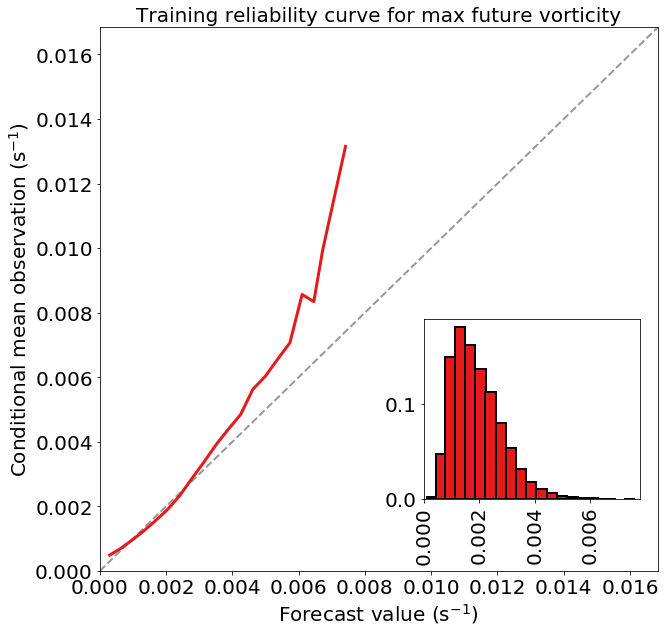

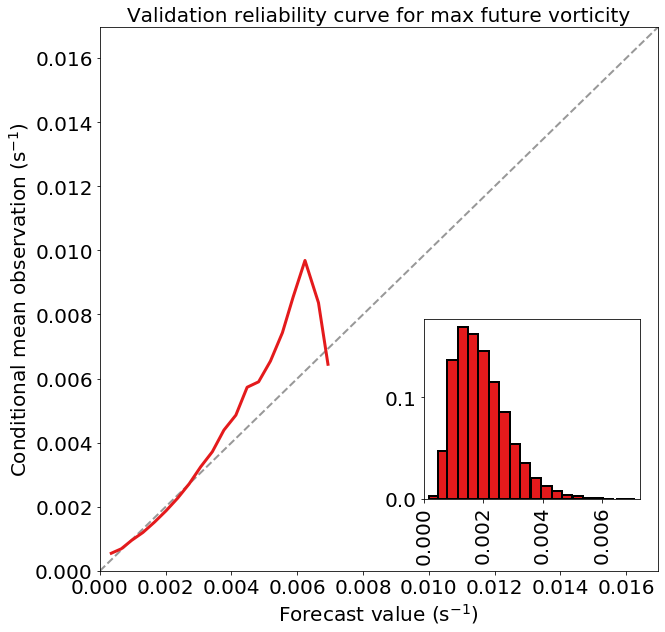

In [46]:
linear_ridge_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=1e5)

_ = utils.train_linear_regression(
    model_object=linear_ridge_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_ridge_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_ridge_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

## Linear Regression with $L_2$: Coefficients

The next cell plots coefficients for linear regression with only the $L_2$ penalty.
<br><br>
Note that coefficients are generally an order of magnitude smaller than in the original model ($10^{-5}$ to $10^{-4}$, instead of $10^{-4}$ to $10^{-3}$).
<br><br>
However, all coefficients are non-zero, because as discussed the $L_2$ penalty does not encourage coefficients to become **exactly** zero.

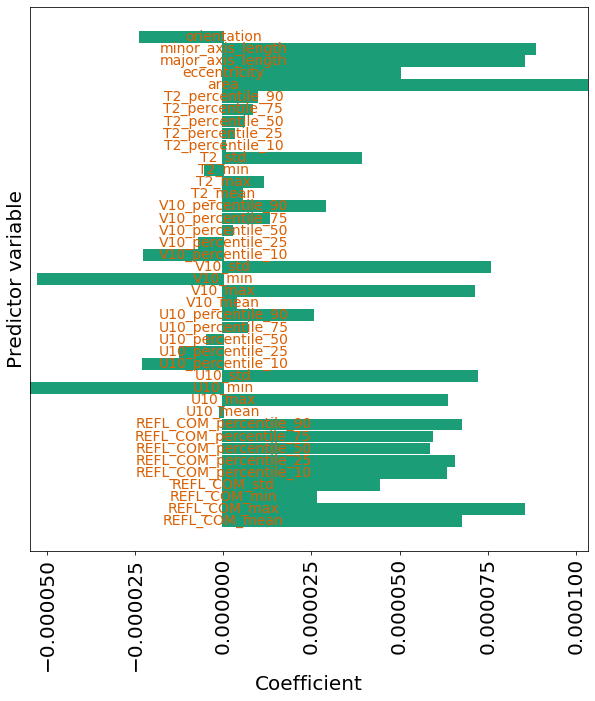

In [47]:
utils.plot_model_coefficients(
    model_object=linear_ridge_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

## Linear Regression with $L_1$: Example

The next cell trains a linear-regression model with only the $L_1$ penalty.  The regularization strength ($\lambda_1$) is $10^{-5}$.
<br><br>
Both training and validation performance get **a bit** worse than in the original model, which means that the $\lambda_1$ value is too high.
<br><br>
However, performance does not decrease as much as it did for $L_2$ regularization.

Training MAE (mean absolute error) = 7.893e-04 s^-1
Training MSE (mean squared error) = 1.168e-06 s^-2
Training bias (mean signed error) = 1.697e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.299
Training MSE skill score (improvement over climatology) = 0.497


--------------------------------------------------


Validation MAE (mean absolute error) = 7.669e-04 s^-1
Validation MSE (mean squared error) = 1.103e-06 s^-2
Validation bias (mean signed error) = 1.086e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.301
Validation MSE skill score (improvement over climatology) = 0.516


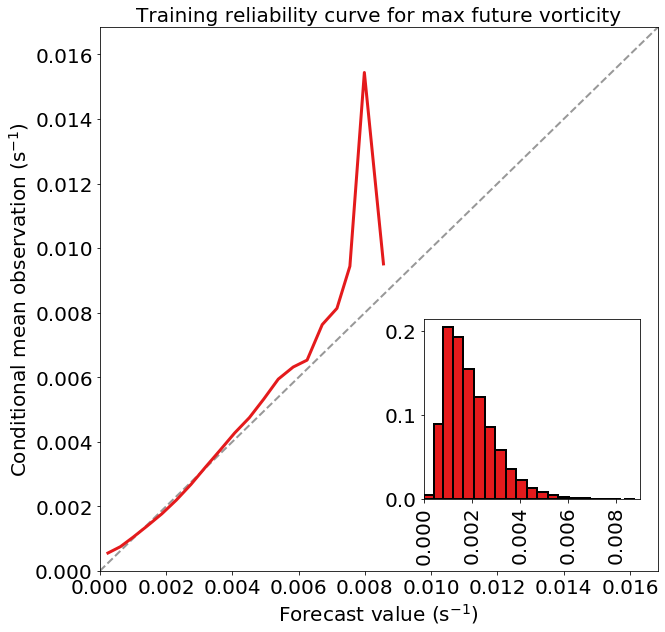

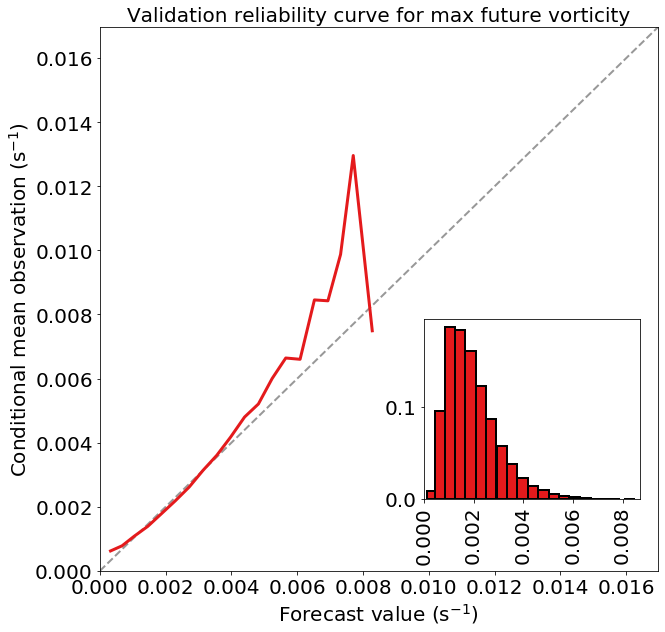

In [48]:
linear_lasso_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=0.)

_ = utils.train_linear_regression(
    model_object=linear_lasso_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_lasso_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_lasso_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

## Linear Regression with $L_1$: Coefficients

The next cell plots coefficients for linear regression with only the $L_1$ penalty.
<br><br>
Non-zero coefficients are generally on the same order of magnitude as the original model ($\sim10^{-4}$).
<br><br>
However, many coefficients (25 of 41) have been "zeroed out".  This means that the model uses only 16 of the 41 predictors.  (Note: This result may vary slightly if you run the model again, since I'm not sure if all the randomness has been controlled.)

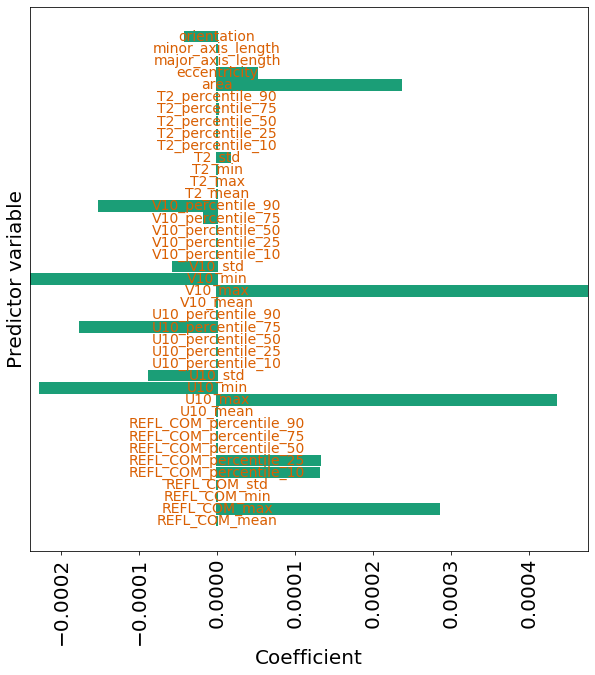

In [49]:
utils.plot_model_coefficients(
    model_object=linear_lasso_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

## Linear Regression with $L_1$ and $L_2$: Example

 - The next cell trains a linear-regression model with both penalties.
 - Whereas $L_1$ only is called the "lasso penalty" and $L_2$ only is called the "ridge penalty," this is called the **"elastic net"**.
<br><br>
 - In the literature you may see people talk about "lasso regression," "ridge regression," and "elastic-net regression". However, the lasso, ridge, and elastic-net penalties can be applied to any kind of model.
 - When people say "lasso regression," "ridge regression," and "elastic-net regression," they generally mean linear regression with the given penalty.
 - However, this is not always true, so be careful.

<br>
In this elastic net makes training and validation performance **much worse**, because the values are too high ($\lambda_1 = 10^{-5}$ and $\lambda_2 = 5$).

Training MAE (mean absolute error) = 8.554e-04 s^-1
Training MSE (mean squared error) = 1.396e-06 s^-2
Training bias (mean signed error) = 3.540e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.241
Training MSE skill score (improvement over climatology) = 0.399


--------------------------------------------------


Validation MAE (mean absolute error) = 8.370e-04 s^-1
Validation MSE (mean squared error) = 1.344e-06 s^-2
Validation bias (mean signed error) = 4.480e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.237
Validation MSE skill score (improvement over climatology) = 0.410


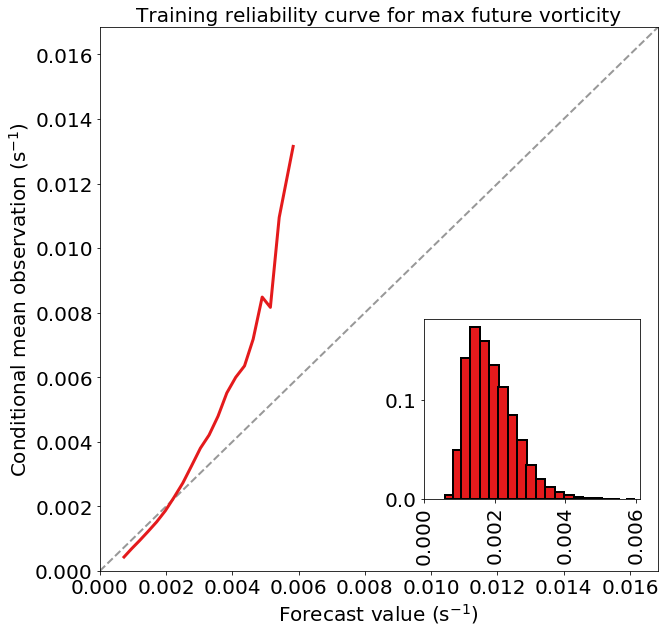

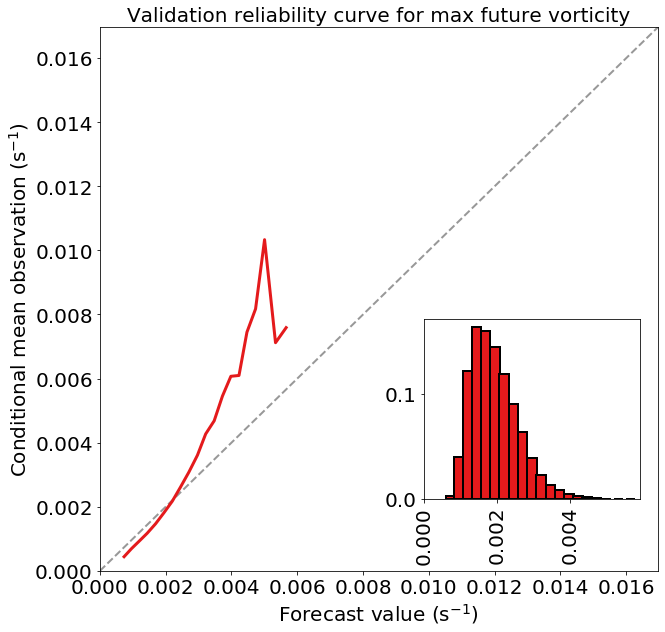

In [50]:
linear_en_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=5.)

_ = utils.train_linear_regression(
    model_object=linear_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linear_en_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_en_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

# Linear Regression with $L_1$ and $L_2$: Coefficients

The next cell plots coefficients for linear regression with both penalties.
<br><br>
In general the coefficients are an order of magnitude smaller than the original model.  Also, there are not many zero coefficients.
<br><br>
This means that, with the chosen $\lambda_1$ and $\lambda_2$, $L_2$ regularization "drowned out" $L_1$ regularization.

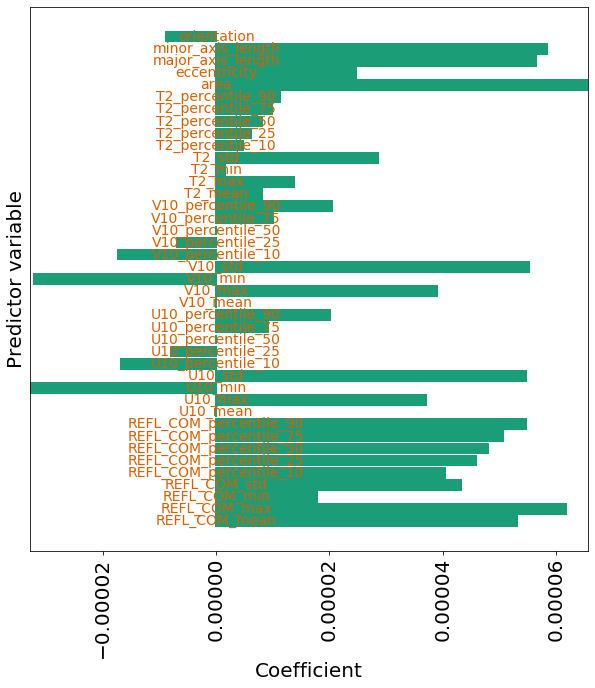

In [51]:
utils.plot_model_coefficients(
    model_object=linear_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

## $L_1$ and $L_2$ Regularization: Exercise

Train a linear-regression model with your own $\lambda_1$ and $\lambda_2$ values.  Investigate performance on the training and validation data and plot coefficients.

In [0]:
# Insert code here.

## Hyperparameter Experiment: $L_1$ and $L_2$ Regularization

The next few cells will show you how to conduct a "hyperparameter experiment".  **The steps in a hyperparameter experiment are as follows.**

 1. **Choose the values to be attempted.**  This is usually based on some *a priori* knowledge about how the model works.  The more expertise you have, the narrower you can make the range of attempted values.  In this case we attempt $\lambda_1 \in \lbrace 10^{-8}, 10^{-7.5}, 10^{-7}, 10^{-6.5}, 10^{-6}, 10^{-5.5}, 10^{-5}, 10^{-4.5}, 10^{-4} \rbrace$ and $\lambda_2 \in \lbrace 10^{-4}, 10^{-3.5}, 10^{-3}, 10^{-2.5}, 10^{-2}, 10^{-1.5}, 10^{-1}, 10^{-0.5}, 10^{0}, 10^{0.5}, 10^{1} \rbrace$.
 2. **Train a model with each combination of hyperparameters.**  In this case there are 9 values for $\lambda_1$ and 11 values for $\lambda_2$, so 99 combinations.  This is called a "grid search".  (Note: There are search methods other than grid search.  These become useful especially when the number of combinations is too large ("combinatiorial explosion"), which usually happens if you are experimenting with anymore than a few hyperparameters.  In this case you can do random search or beam search, use a genetic algorithm to evolve the hyperparameters, etc.  But we will stick with grid search in this module.)
 3. **Evaluate each model on the validation data.**
 4. **Find the model that performs best on the validation data.**  Again, there are many ways to define "best".  In this case we will select the model with the highest MAE skill score.

## Hyperparameter Experiment: Training

The next cell performs steps 1 and 2 of the hyperparameter experiment (defining the values to be attempted and training the models).

In [52]:
lambda1_values = numpy.logspace(-8, -4, num=9)
lambda2_values = numpy.logspace(-4, 1, num=11)

num_lambda1 = len(lambda1_values)
num_lambda2 = len(lambda2_values)

validation_mae_matrix_s01 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_matrix_s02 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mae_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)

mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

for i in range(num_lambda1):
    for j in range(num_lambda2):
        this_message_string = (
            'Training model with lasso coeff = 10^{0:.1f}, ridge coeff = '
            '10^{1:.1f}...'
        ).format(
            numpy.log10(lambda1_values[i]), numpy.log10(lambda2_values[j])
        )

        print(this_message_string)

        this_model_object = utils.setup_linear_regression(
            lambda1=lambda1_values[i], lambda2=lambda2_values[j]
        )

        _ = utils.train_linear_regression(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table)

        these_validation_predictions = this_model_object.predict(
            validation_predictor_table.as_matrix()
        )

        this_evaluation_dict = utils.evaluate_regression(
            target_values=validation_target_table[utils.TARGET_NAME].values,
            predicted_target_values=these_validation_predictions,
            mean_training_target_value=mean_training_target_value,
            verbose=False, create_plots=False)

        validation_mae_matrix_s01[i, j] = this_evaluation_dict[
            utils.MAE_KEY]
        validation_mse_matrix_s02[i, j] = this_evaluation_dict[
            utils.MSE_KEY]
        validation_mae_skill_matrix[i, j] = this_evaluation_dict[
            utils.MAE_SKILL_SCORE_KEY]
        validation_mse_skill_matrix[i, j] = this_evaluation_dict[
            utils.MSE_SKILL_SCORE_KEY]

Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^1.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-7.5, ridge co

## Hyperparameter Experiment: Validation

The next cell performs step 3 of the hyperparameter experiment (evaluates each model on the validation data).

Text(0.5, 1.0, 'MSE skill score on validation data')

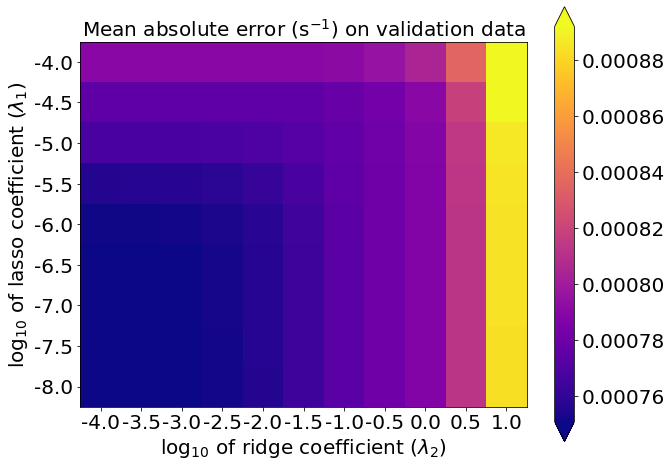

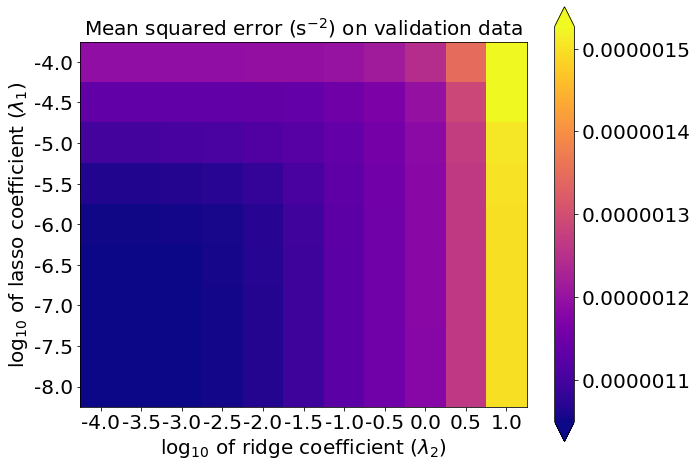

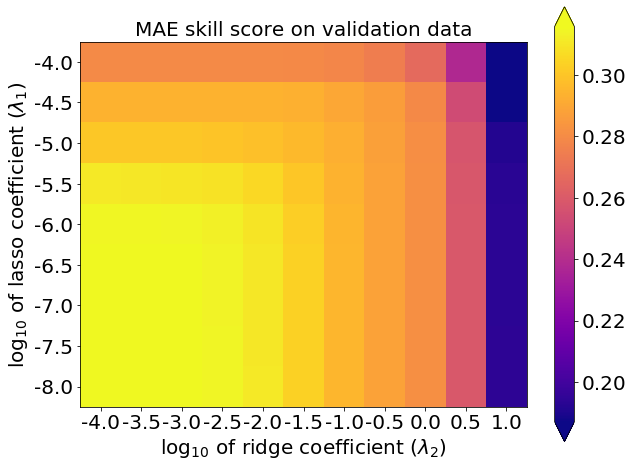

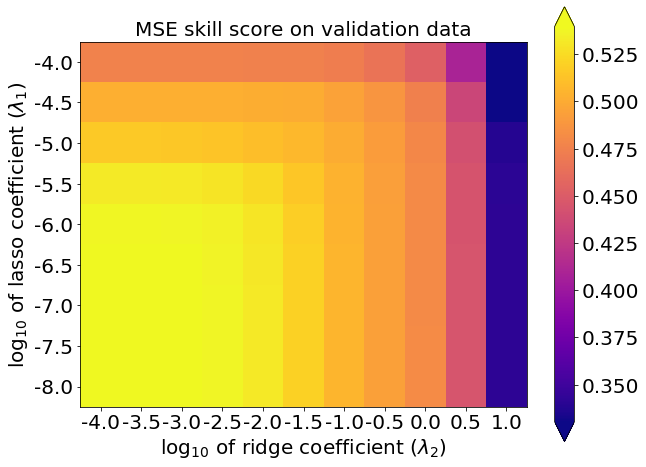

In [53]:
utils.plot_scores_2d(
    score_matrix=validation_mae_matrix_s01,
    min_colour_value=numpy.percentile(validation_mae_matrix_s01, 1.),
    max_colour_value=numpy.percentile(validation_mae_matrix_s01, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean absolute error (s$^{-1}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_matrix_s02,
    min_colour_value=numpy.percentile(validation_mse_matrix_s02, 1.),
    max_colour_value=numpy.percentile(validation_mse_matrix_s02, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean squared error (s$^{-2}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mae_skill_matrix,
    min_colour_value=numpy.percentile(validation_mae_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mae_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MAE skill score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_skill_matrix,
    min_colour_value=numpy.percentile(validation_mse_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mse_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MSE skill score on validation data')

## Hyperparameter Experiment: Selection

The next cell performs step 4 of the hyperparameter experiment (select model).

Best MAE skill score on validation data = 0.316 ... corresponding lasso coeff = 10^-6.5, ridge coeff = 10^-4.0
Testing MAE (mean absolute error) = 8.257e-04 s^-1
Testing MSE (mean squared error) = 1.413e-06 s^-2
Testing bias (mean signed error) = -8.985e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.555


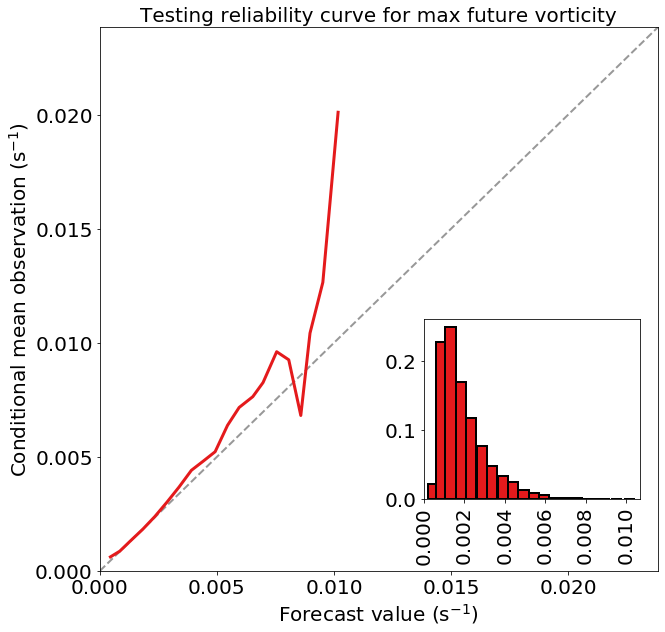

In [54]:
best_linear_index = numpy.argmax(numpy.ravel(validation_mae_skill_matrix))

best_lambda1_index, best_lambda2_index = numpy.unravel_index(
    best_linear_index, (len(lambda1_values), len(lambda2_values))
)

best_lambda1 = lambda1_values[best_lambda1_index]
best_lambda2 = lambda2_values[best_lambda2_index]
best_validation_maess = numpy.max(validation_mae_skill_matrix)

message_string = (
    'Best MAE skill score on validation data = {0:.3f} ... corresponding '
    'lasso coeff = 10^{1:.1f}, ridge coeff = 10^{2:.1f}'
).format(
    best_validation_maess, numpy.log10(best_lambda1),
    numpy.log10(best_lambda2)
)

print(message_string)

final_model_object = utils.setup_linear_regression(
    lambda1=best_lambda1, lambda2=best_lambda2)

_ = utils.train_linear_regression(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

testing_predictions = final_model_object.predict(
    testing_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

this_evaluation_dict = utils.evaluate_regression(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_target_values=testing_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='testing')

## Hyperparameter Experiment: Exercise

Based on the first hyperparameter experiment, write your own hyperparameter experiment (with a different set of $\lambda_1$ and $\lambda_2$ values).  See if you can find a $\lambda_1$-$\lambda_2$ combo that works better on the validation data.  If you find a combo that works better on the validation data, see if it also works better on the testing data.  If not, you have overfit $\lambda_1$ and $\lambda_2$ to the validation data.

In [0]:
# Insert code here.

## K-Fold Cross Validation

Normally, we split data into training, validation, and testing sets, as shown above. (This is called the **holdout method**.) But what if our small testing set is not representative of the data our model might see? i.e. What if we have a "bad split" and just don't know it? 

**K-fold cross validation** is a way to ensure that our model is performing well on different kinds of data by using different portions of the data in the testing set. 

Here's a summary of the method: 
```
Split the data into K parts. 
for i in range(0, K):
    Take part i as the testing set. 
    Take the rest of the parts as the training set. 
    Train the model on the training set and evaluate it on the testing set. 
Collect all the evaluations scores from K different runs and combine them
to summarize your final model.
```  

Let's apply K-fold cross validation to our model and see how it does:

In [ ]:
# k fold cross validation with k=5
mse = []

folds = create_folds()

for i in range(0,5):
    print(MINOR_SEPARATOR_STRING)
    print("Fold "+str(i))

    test = folds[i]
    train = [folds[(i+1)%5], folds[(i+2)%5],folds[(i+3)%5],folds[(i+4)%5]] 
    normalized_test, normalized_train = normalize(test=test, train=train)
    
    evaluation_dict = train_linear_model(test=normalized_test, train=normalized_train)
    
    # MSE or whichever variable you'd like to track
    mse.append(evaluation_dict["mean_squared_error"])

print("Average MSE: " + str(sum(mse) / len(mse)))


def create_folds():
    """
    Return:
    ------
    folds: Python list of data folds
    """
    ## Insert code here
    return folds

def normalize(test, train):
    ## Insert code here
    return normalized_test, normalized_train

def train_linear_model(test, train):
    """
    Hint:
    ----
    utils.evaluate_regression() returns a dictionary with the following keys:
        evaluation_dict['mean_absolute_error']
        evaluation_dict['mean_squared_error']
        evaluation_dict['mean_bias']
        evaluation_dict['mae_skill_score']: MAE skill score (fractional improvement
            over climatology, in range -1...1).
        evaluation_dict['mse_skill_score']: MSE skill score (fractional improvement
            over climatology, in range -1...1).
    Return:
    ------
    evaluation_dict
    """
    ## Insert code here.
    return evaluation_dict



## Binary Classification

 - **The rest of this module focuses on binary classification, rather than regression.**
 - "Regression" is the prediction of a real number (*e.g.*, above, where we predicted max future vorticity).
 - "Classification" is the prediction of a category (*e.g.*, low, medium, or high max future vorticity).
<br><br>
 - **In binary classification there are two categories.**
 - Thus, prediction takes the form of answering a **yes-or-no question.**
 - We will use the same target variable (max future vorticity), except we will binarize it.
 - The problem will be predicting whether or not max future vorticity exceeds a threshold.

### Binarization

 - The next cell "binarizes" the target variable (turns each value into a 0 or 1, yes or no).
 - The threshold is the 90$^{\textrm{th}}$ percentile of max future vorticity over all training examples.
 - The same threshold is used to binarize training, validation, and testing data.

In [55]:
binarization_threshold = utils.get_binarization_threshold(
    csv_file_names=training_file_names, percentile_level=90.)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    'Real-numbered target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    '\nBinarized target values for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold)

testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)


Binarization threshold for "RVORT1_MAX-future_max" = 3.8500e-03


--------------------------------------------------


Real-numbered target values for the first training examples:
[0.00035 0.00195 0.00241 0.00233 0.00254 0.00174 0.0012  0.0007  0.0005
 0.0008 ]

Binarization threshold = 3.850e-03 s^-1

Binarized target values for the first training examples:
[0 0 0 0 0 0 0 0 0 0]


### Binarization: Exercise

If you want to use another percentile (instead of the 90$^{\textrm{th}}$) for binarization, feel free to do so here.  For example, if you want to work with a non-rare event, you could use something like the 50$^{\textrm{th}}$ percentile.  If you want to work with an even rarer event, you could use the 99$^{\textrm{th}}$ percentile.

In [0]:
# Insert code here.

## Contingency Table

**Most evaluation methods for binary classification are based on the contingency table** (or "confusion matrix"), shown below.

<img src="contingency_table.png" alt="Contingency table" width="500" />

 - $a$ = number of true positives (forecast = label = "yes")
 - $b$ = number of false positives (forecast = "yes" but label = "no")
 - $c$ = number of false negatives (forecast = "no" but label = "yes")
 - $d$ = number of true negatives (forecast = label = "no")
<br><br>
 - **Problem**: most classification models (including logistic regression) output probabilities, rather than yeses and nos.
 - **Solution**: determinize the probabilities.
 - "Determinize" is just a fancy way of saying "turn the probabilities into yeses and nos".
 - This is done with the following equation, where $p$ = probability; $p^*$ = threshold; and $\hat{y}$ is the resulting deterministic forecast.

$\hat{y} = \begin{cases}1,\quad\textrm{if }p \ge p^* \\0,\quad\textrm{otherwise}\end{cases}$

 - The best threshold is usually **not** 0.5.
 - Keep in mind that $p^*$ is a hyperparameter, so it should be optimized on the validation data.

**The following scores can be computed from the contingency table.**

<img src="ct_scores.png" alt="Scores from contingency table" width="500" />

## ROC Curve

 - The ROC curve plots POD (probability of detection) vs. POFD (probability of false detection) with varying threshold $p^*$.
 - Each point in the curve corresponds to one $p^*$ value.
 - For $p^*$ = 0, POD = POFD = 1.
 - For $p^*$ = 1, POD = POFD = 0.

**Two numbers can be used to summarize the how well a model is doing on a ROC curve:**

 - Maximum Peirce score (POD - POFD) over all thresholds
 - Area under the curve (AUC)
 - Generally, an AUC $\ge$ 0.9 is considered "excellent".
 - AUC = 0.5 (dashed grey line) for a random model.

 <img src="roc.png" alt="ROC curve example" width="500" />

## Performance Diagram

 - The performance diagram plots POD (probability of detection) vs. success ratio (1 - FAR).
 - Again, each point corresponds to one $p^*$ value.
 - For $p^*$ = 0, POD = 1 and success ratio is minimized.
 - For $p^*$ = 1, POD = 0 and success ratio is maximized.

CSI (critical success index) and frequency bias are contoured in the background.  They can be expressed in POD&ndash;success-ratio space as follows.
<br><br>
$\textrm{bias} = \frac{\textrm{POD}}{\textrm{SR}}$
<br>
$\textrm{CSI}^{-1} = \textrm{POD}^{-1} + \textrm{SR}^{-1} - 1$
<br><br>

**A few numbers can be used to summarize the how well a model is doing on a performance diagram:**

 - Maximum CSI
 - Frequency bias at maximum CSI (should occur with a frequency bias near 1.0)
 - Area under curve
<br><br>
 - However, unlike the ROC curve, these numbers are very sensitive to the class distribution.
 - Thus, thresholds for "good" and "bad" depend on the class distribution.
 - For some rare events a max CSI of 0.10 may be excellent; for common events a max CSI of 0.8 may be poor.

 <img src="performance_diagram.png" alt="Performance diagram example" width="500" />

## Attributes Diagram

 - The attributes diagram is a reliability curve for binary classification, plus a few reference lines in the background.
 - **Plots forecast probability vs. conditional mean frequency.**
 - This answers the question: **"given forecast probability $p$, how likely is the event?"**
<br><br>
 - **For perfect reliability, conditional event frequency = forecast probability always.**
 - This is represented by the diagonal grey line ($x = y$), called the "perfect-reliability line".
 - The vertical grey line is the "climatology line," representing the event frequency in the training data, which is just called "climatology".  Climatology in our case is 10%.  If the model always forecast climatology, the reliability curve would collapse to a single point on this line.
 - The horizontal grey line is the "no-resolution line," also based on training-set climatology.  If the model were completely random, the reliability curve would approx follow this line.
<br><br>
 - **The blue shading is the "positive-skill area," where Brier skill score $>$ 0.**
 - Brier skill score (BSS) is the Brier score (BS) relative to climatology.
<br><br>
$\textrm{BS} = \frac{1}{N} \sum\limits_{i = 1}^{N} (p_i - y_i)^2$
<br>
$\textrm{BSS} = \frac{\textrm{BS}_{\textrm{climo}} - \textrm{BS}}{\textrm{BS}_{\textrm{climo}}}$

<img src="attributes_diagram.png" alt="Attributes diagram example" width="500" />